In [1]:
# Import necessary libraries
import numpy as np                 # For numerical operations and array handling
import pandas as pd                # For data manipulation and analysis
import matplotlib.pyplot as plt    # For data visualization
import time                        # For tracking execution time

In [2]:
# Load the MNIST training and test datasets from CSV files
# Source for data: https://ml-cheatsheet.readthedocs.io/en/latest/datasets.html
data_train = pd.read_csv('mnist_train.csv')
data_test = pd.read_csv('mnist_test.csv')

# Convert the training DataFrame to a NumPy array and shuffle the data
train = np.array(data_train)
np.random.shuffle(train)  # Ensures the training data is randomly ordered
m, n = train.shape        # m = number of training examples, n = total number of features (including label)

# Convert the test DataFrame to a NumPy array and shuffle the data
test = np.array(data_test)
np.random.shuffle(test)   # Randomize test data to avoid ordering bias

In [3]:
# Transpose the training data so that each column represents one example
train = train.T

# Extract labels (Y) from the first row (originally the first column before transpose)
train_Y = train[0]

# Extract features (X) from the remaining rows and normalize pixel values to the range [0, 1]
train_X = train[1:n].astype(np.float32) / 255

# Transpose the test data so that each column represents one example
test = test.T

# Extract labels (Y) from the first row
test_Y = test[0]

# Extract features (X) from the remaining rows and normalize pixel values
test_X = test[1:n].astype(np.float32) / 255

# Define the input layer size based on the number of features (e.g., 784 for 28x28 MNIST images)
input_size = train_X.shape[0]

In [4]:
# Initialize weights and biases using He initialization for a 3-layer neural network
def initialize_parameters(input_size, layer_1, layer_2):
    # Initialize weights for hidden layer 1 with He initialization
    w1 = np.random.randn(layer_1, input_size) * np.sqrt(2. / input_size)
    
    # Initialize biases for hidden layer 1 with small constant (e.g., 0.1 to avoid dead neurons in ReLU)
    b1 = np.full((layer_1, 1), 0.1)

    # Initialize weights for hidden layer 2 with He initialization
    w2 = np.random.randn(layer_2, layer_1) * np.sqrt(2. / layer_1)
    
    # Initialize biases for hidden layer 2
    b2 = np.full((layer_2, 1), 0.1)

    # Initialize weights for output layer (10 classes for MNIST) with He initialization
    wo = np.random.randn(10, layer_2) * np.sqrt(2. / layer_2)
    
    # Initialize biases for output layer
    bo = np.full((10, 1), 0.1)
    
    return w1, b1, w2, b2, wo, bo

In [5]:
# Leaky ReLU activation function for forward propagation
# Helps prevent dead neurons by allowing a small gradient when z < 0
def ReLU(z):
    return np.maximum(0.01 * z, z)

# Derivative of the Leaky ReLU function for use during backpropagation
def ReLU_prime(z):
    return np.where(z > 0, 1.0, 0.01)

# Softmax activation function for output layer
# Converts raw logits into a probability distribution across classes
def softmax(z):
    z_stable = z - np.max(z, axis=0, keepdims=True)  # Subtract max for numerical stability
    exp_z = np.exp(z_stable)
    return exp_z / np.sum(exp_z, axis=0, keepdims=True)

In [6]:
# Forward propagation through a 3-layer neural network
def forward_propagation(w1, b1, w2, b2, wo, bo, X):
    # Linear transformation for hidden layer 1
    z1 = w1 @ X + b1
    
    # Apply Leaky ReLU activation to hidden layer 1
    h1 = ReLU(z1)
    
    # Linear transformation for hidden layer 2
    z2 = w2 @ h1 + b2
    
    # Apply Leaky ReLU activation to hidden layer 2
    h2 = ReLU(z2)
    
    # Linear transformation for output layer
    zo = wo @ h2 + bo
    
    # Apply softmax to obtain output probabilities (ŷ)
    y_hat = softmax(zo)
    
    # Return all intermediate values needed for backpropagation
    return z1, h1, z2, h2, zo, y_hat

In [7]:
# Convert labels to one-hot encoded vectors
def one_hot_encoder(Y, num_classes=10):
    one_hot_Y = np.eye(num_classes)[Y].T
    return one_hot_Y

In [8]:
# Compute average cross-entropy loss between predictions and true labels
def cross_entropy_loss(y_hat, y_true):
    epsilon = 1e-12  # Avoid log(0)
    y_hat = np.clip(y_hat, epsilon, 1. - epsilon)
    loss = -np.sum(y_true * np.log(y_hat)) / y_true.shape[1]
    return loss

In [9]:
# Perform backpropagation to compute gradients of weights and biases for all layers
def back_propagation(z1, h1, z2, h2, zo, y_hat, w1, w2, wo, X, Y):
    # Convert true labels to one-hot encoding
    one_hot_Y = one_hot_encoder(Y)
    
    # Number of training examples
    m = X.shape[1]
    
    # Calculate output layer error (difference between predictions and true labels)
    dzo = y_hat - one_hot_Y
    
    # Gradients for output layer weights and biases
    dwo = (1 / m) * (dzo @ h2.T)
    dbo = (1 / m) * np.sum(dzo, axis=1, keepdims=True)

    # Backpropagate error to second hidden layer and apply derivative of Leaky ReLU
    dz2 = (wo.T @ dzo) * ReLU_prime(z2)
    
    # Gradients for second hidden layer weights and biases
    dw2 = (1 / m) * (dz2 @ h1.T)
    db2 = (1 / m) * np.sum(dz2, axis=1, keepdims=True)

    # Backpropagate error to first hidden layer and apply derivative of Leaky ReLU
    dz1 = (w2.T @ dz2) * ReLU_prime(z1)
    
    # Gradients for first hidden layer weights and biases
    dw1 = (1 / m) * (dz1 @ X.T)
    db1 = (1 / m) * np.sum(dz1, axis=1, keepdims=True)
    
    # Return gradients for all layers
    return dw1, db1, dw2, db2, dwo, dbo

In [10]:
# Update weights and biases using gradient descent
# alpha: learning rate controlling step size of updates
def update_parameters(w1, b1, w2, b2, wo, bo, dw1, db1, dw2, db2, dwo, dbo, alpha):
    # Update weights and biases for hidden layer 1
    w1 = w1 - alpha * dw1
    b1 = b1 - alpha * db1

    # Update weights and biases for hidden layer 2
    w2 = w2 - alpha * dw2
    b2 = b2 - alpha * db2

    # Update weights and biases for output layer
    wo = wo - alpha * dwo
    bo = bo - alpha * dbo 
    
    # Return updated parameters
    return w1, b1, w2, b2, wo, bo

In [11]:
def get_predictions(y_hat):
    # Return class with highest probability per example
    return np.argmax(y_hat, axis=0)

def get_accuracy(predictions, Y):
    # Compute fraction of correct predictions
    return np.sum(predictions == Y) / Y.size

def make_predictions(X, w1, b1, w2, b2, wo, bo):
    # Forward propagate and return predicted classes
    _, _, _, _, _, y_hat = forward_propagation(w1, b1, w2, b2, wo, bo, X)
    return get_predictions(y_hat)

In [12]:
# Set model hyperparameters based on input data
def get_model_hyperparameters(X):
    decay = 0.05
    input_size = X.shape[0]
    layer_1, layer_2 = 128, 128
    return input_size, decay, layer_1, layer_2

In [13]:
# Run one training epoch with mini-batch gradient descent
def run_epoch(X, Y, w1, b1, w2, b2, wo, bo, alpha, batch_size):
    num_samples = X.shape[1]
    
    # Shuffle data indices for randomness in batching
    indices = np.arange(num_samples)
    np.random.shuffle(indices)
    
    # Shuffle inputs and labels accordingly
    X_shuffled = X[:, indices]
    Y_shuffled = Y[indices]

    epoch_loss = 0
    num_batches = int(np.ceil(num_samples / batch_size))

    for start in range(0, num_samples, batch_size):
        end = start + batch_size
        
        # Select current batch
        X_batch = X_shuffled[:, start:end]
        Y_batch = Y_shuffled[start:end]

        # Forward propagation to compute predictions
        z1, h1, z2, h2, zo, y_hat = forward_propagation(w1, b1, w2, b2, wo, bo, X_batch)
        
        # Compute cross-entropy loss for batch
        batch_loss = cross_entropy_loss(y_hat, one_hot_encoder(Y_batch, num_classes=10))
        epoch_loss += batch_loss

        # Backpropagation to compute gradients
        dw1, db1, dw2, db2, dwo, dbo = back_propagation(z1, h1, z2, h2, zo, y_hat, w1, w2, wo, X_batch, Y_batch)

        # Update weights and biases using computed gradients
        w1, b1, w2, b2, wo, bo = update_parameters(w1, b1, w2, b2, wo, bo, dw1, db1, dw2, db2, dwo, dbo, alpha)

    # Calculate average loss over all batches in the epoch
    avg_loss = epoch_loss / num_batches
    
    return w1, b1, w2, b2, wo, bo, avg_loss

In [14]:
# Train the neural network for a specified number of epochs
def train_loop(X, Y, input_size, layer_1, layer_2, alpha_initial, epochs_to_run, decay=0.05, batch_size=128, verbose=True, max_time_sec=None):
    # Initialize weights and biases
    w1, b1, w2, b2, wo, bo = initialize_parameters(input_size, layer_1, layer_2)
    
    # Lists to store training progress
    EPOCH, ACCURACY, LOSS = [], [], []
    
    # One-hot encode true labels
    y_true = one_hot_encoder(Y, num_classes=10)

    start_time = time.time()

    for epoch in range(epochs_to_run):
        # Decay learning rate over epochs
        alpha = alpha_initial / (1 + decay * epoch)
        
        # Train one epoch and get updated parameters and loss
        w1, b1, w2, b2, wo, bo, loss = run_epoch(X, Y, w1, b1, w2, b2, wo, bo, alpha, batch_size)

        # Print header at start of training
        if epoch == 0 and verbose:
            print(f"{'Epoch':<10}{'Accuracy(%)':<15}{'Loss':<10}{'Alpha':<10}")

        # Periodically print progress every 5 epochs
        if epoch % 5 == 0 and verbose:
            _, _, _, _, _, y_hat = forward_propagation(w1, b1, w2, b2, wo, bo, X)
            acc = get_accuracy(get_predictions(y_hat), Y)
            print(f"{epoch:<10}{acc*100:<15.2f}{loss:<10.4f}{alpha:<10.4f}")

        # Record metrics every epoch
        if epoch % 1 == 0:
            _, _, _, _, _, y_hat = forward_propagation(w1, b1, w2, b2, wo, bo, X)
            acc = get_accuracy(get_predictions(y_hat), Y)
            EPOCH.append(epoch)
            ACCURACY.append(acc * 100)
            LOSS.append(loss)

        # Early stop if max time exceeded
        if max_time_sec and (time.time() - start_time) >= max_time_sec * 1.05:
            if verbose:
                print(f"\nStopping early at epoch {epoch} to respect time limit...")
            break

    elapsed_time = int(time.time() - start_time)
    return w1, b1, w2, b2, wo, bo, elapsed_time, EPOCH, ACCURACY, LOSS

In [20]:
# Run a short training trial to estimate average time per epoch
def estimate_epochs(X, Y, alpha_initial, input_size, layer_1, layer_2, trial_epochs=10, batch_size=128):
    print(f"\nRunning a trial of {trial_epochs} epochs to estimate training speed...")
    
    # Run training for a small number of epochs without verbose output
    _, _, _, _, _, _, trial_time, *_ = train_loop(X, Y, input_size, layer_1, layer_2, alpha_initial, trial_epochs, verbose=False, batch_size=batch_size)
    
    # Calculate average time taken per epoch
    time_per_epoch = trial_time / trial_epochs
    
    print(f"\nEstimated time per epoch: {time_per_epoch:.2f} seconds")
    return time_per_epoch

In [21]:
# Plot training accuracy and loss over epochs with two y-axes for clarity
def plot_training_results(EPOCH, ACCURACY, LOSS):
    fig, ax1 = plt.subplots(figsize=(10, 5))
    
    # Plot accuracy on left y-axis
    color1 = 'tab:blue'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy (%)', color=color1)
    ax1.plot(EPOCH, ACCURACY, color=color1)
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.grid(True)

    # Plot loss on right y-axis
    ax2 = ax1.twinx()
    color2 = 'tab:red'
    ax2.set_ylabel('Loss', color=color2)
    ax2.plot(EPOCH, LOSS, color=color2)
    ax2.tick_params(axis='y', labelcolor=color2)

    plt.title("Training Accuracy and Loss vs Epoch")
    fig.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

In [22]:
# Perform gradient descent training with optional time-based epoch estimation
def gradient_descent_optimization(X, Y, alpha_initial, epochs=None, batch_size=128):
    # Get model parameters and decay rate
    input_size, decay, layer_1, layer_2 = get_model_hyperparameters(X)
    trial_epochs = 10

    if epochs is None:
        # Prompt user for desired training time in minutes
        while True:
            try:
                minutes_input = float(input("Enter desired training time in minutes: ").strip())
                if minutes_input <= 0:
                    print("Please enter a positive number.")
                    continue
                break
            except ValueError:
                print("Invalid input. Please enter a number.")

        total_time_sec = minutes_input * 60

        # Estimate time per epoch using a short trial run
        time_per_epoch = estimate_epochs(X, Y, alpha_initial, input_size, layer_1, layer_2, trial_epochs, batch_size)
        
        # Calculate max epochs to fit within the desired time (95% of total time reserved)
        estimated_epochs = max(1, int((total_time_sec * 0.95) // time_per_epoch))
        print(f"\nTotal epochs set to {estimated_epochs} to fit within {minutes_input} minutes.\n")

        # Train model with estimated epochs and time limit
        w1, b1, w2, b2, wo, bo, final_time, EPOCH, ACCURACY, LOSS = train_loop(
            X, Y, input_size, layer_1, layer_2, alpha_initial, estimated_epochs,
            batch_size=batch_size, max_time_sec=total_time_sec * 0.95
        )
    else:
        # Train model with fixed number of epochs
        w1, b1, w2, b2, wo, bo, final_time, EPOCH, ACCURACY, LOSS = train_loop(
            X, Y, input_size, layer_1, layer_2, alpha_initial, epochs, batch_size=batch_size
        )

    # Format and print total training time
    hours = final_time // 3600
    minutes = (final_time % 3600) // 60
    seconds = final_time % 60
    print(f"\nTotal training time: {hours:02d}:{minutes:02d}:{seconds:02d}\n")

    # Plot training metrics
    plot_training_results(EPOCH, ACCURACY, LOSS)

    # Return trained parameters and elapsed time
    return w1, b1, w2, b2, wo, bo, final_time

### Run the neural network below and test its accuracy.

Enter desired training time in minutes:  5



Running a trial of 10 epochs to estimate training speed...
Estimated time per epoch: 2.00 seconds

Setting total epochs to 142 to fit within 5.0 minutes.

Epoch     Accuracy(%)    Loss      Alpha     
0         65.37          1.6522    0.5000    
5         91.83          0.2583    0.4000    
10        94.62          0.1871    0.3333    
15        95.47          0.1575    0.2857    
20        95.93          0.1394    0.2500    
25        96.33          0.1271    0.2222    
30        96.63          0.1177    0.2000    
35        96.90          0.1097    0.1818    
40        97.10          0.1038    0.1667    
45        97.22          0.0985    0.1538    
50        97.34          0.0941    0.1429    
55        97.45          0.0903    0.1333    
60        97.56          0.0871    0.1250    
65        97.63          0.0843    0.1176    
70        97.71          0.0815    0.1111    
75        97.80          0.0792    0.1053    
80        97.86          0.0769    0.1000    
85        97.92 

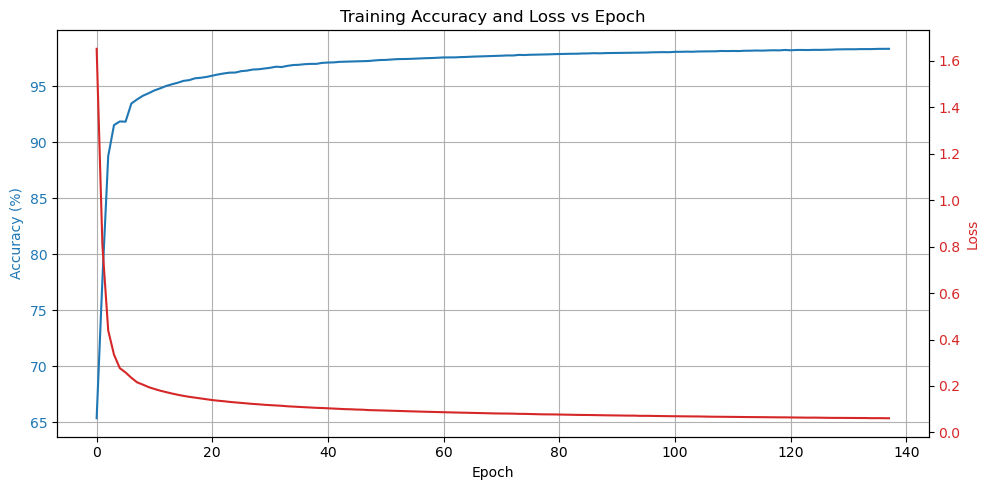

Test set accuracy: 97.14 %


In [18]:
# Train the model using mini-batch gradient descent
w1, b1, w2, b2, wo, bo, _ = gradient_descent_optimization(train_X, train_Y, 0.5, epochs=None, batch_size=4096)

# Evaluate and print model accuracy on unseen test data
accuracy = get_accuracy(make_predictions(test_X, w1, b1, w2, b2, wo, bo), test_Y) * 100
print(f"Test set accuracy: {accuracy:.2f} %")